In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True


# Read data

In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y 

In [3]:
###
#cal_PMf  
###
u=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    u[i]=a.T

###
#obs_PMf
###
v=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    v[i]=a.T

print(np.shape(u))
print(np.shape(v))

(605, 5112)
(605, 5112)


In [4]:
XRestruct_Fun=u
YRestruct_Fun=v
print(np.shape(XRestruct_Fun))
print(np.shape(YRestruct_Fun))

(605, 5112)
(605, 5112)


In [5]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([544,5112])
Yhat_train = np.zeros([544,5112])
Xhat_val = np.zeros([61,5112])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,5112])
Yhat_test = np.zeros([61,5112])

for i in range (0,544):
    for j in range (0,5112):    
        Xhat_train[i][j] = Xhat[i][j]
        Yhat_train[i][j] = Yhat[i][j]
        
for i in range (544,605):
    for j in range (0,5112):
        Xhat_val[i-544][j] = Xhat[i][j]
        Yhat_val[i-544][j] = Yhat[i][j]     
        
for i in range (544,605):
    for j in range (0,5112):
        Xhat_test[i-544][j] = Xhat[i][j]
        Yhat_test[i-544][j] = Yhat[i][j]
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(544, 5112)
Yhat_train
(544, 5112)
Xhat_val
(61, 5112)
Yhat_val
(61, 5112)
Xhat_test
(61, 5112)
Yhat_test
(61, 5112)


# Modeling

In [6]:
x_train = torch.from_numpy(Xhat_train).float()
y_train = torch.from_numpy(Yhat_train).float()
x_val = torch.from_numpy(Xhat_val).float()
y_val = torch.from_numpy(Yhat_val).float()
x_test = torch.from_numpy(Xhat_test).float()
y_test = torch.from_numpy(Yhat_test).float()

In [7]:
class PytorchLightningModel(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(5112 , 5112)

    def forward(self, x): 
        ouput = self.layer1(x)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=544 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("train_loss_MAE", loss)
        return {'loss' : loss , 'log' : logs }

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("test_loss_MAE", loss)
        return {'loss' : loss ,'log' : logs}

    # def test_eposh_end(self, outputs):
    #     avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    #     logs = {'test_loss': avg_loss}      
    #     #return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }
    #     return {'avg_test_loss': avg_loss, 'log': logs}

    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("val_loss_MAE", loss)
        return {'loss' : loss ,  'log' : logs}
    
    
    # def validation_epoch_end(self, outputs):
    #     avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    #     logs = {'val_loss': avg_loss}
    #     return {'avg_val_loss': avg_loss, 'log' : logs, 'progress_bar': logs}

In [ ]:
logger1 = TensorBoardLogger("jupyterNB_logs", name="NN_72hr")
logger2 = CSVLogger("jupyterNB_logs", name="NN_72hr_csv")
model = PytorchLightningModel() 
trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger2)
trainer.fit(model)
trainer.test(model)

# Result

In [9]:
df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/NN_72hr_csv/version_1=0/metrics.csv")
s=np.array(df['val_loss_MAE'].fillna(np.nanmean(df['val_loss_MAE'])))
score=np.min(s)
print(score)

6.066917419433594


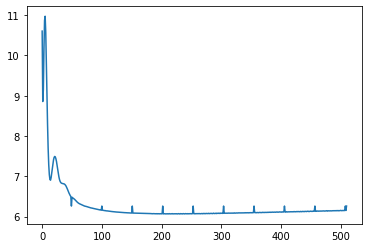

In [11]:
plt.plot(s)